In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import sys
sys.path.insert(1, "../python/functions")
sys.path.insert(2, "../python/architecture")

In [3]:
from data_prep_functions import bike_prep
from model_functions import *
from plotting_functions import *
import no_gpu
import reproducible
from training_callback import BatchMSE

In [4]:
X_train, X_test, y_train, y_test = bike_prep()

In [5]:
# use samller dataset for increased speed
X_train = X_train[:1000]
X_test = X_test[:500]
y_train = y_train[:1000]
y_test = y_test[:500]

n_cols = X_train.shape[1]

In [6]:
particles = 100
early_stopping = False
early_stopping_diff = 1
batch_normal = False  # evtl. noch einbauen, obwohl im Paper nicht gemacht (aber Achtung mit den Dimensionen unten!!!)
shuffle = True
randomization = False

In [7]:
layers = 5
neurons = [64, 32, 32, 16, 1]
n_cols = X_train.shape[1]
batch_size = 50
epochs = 20

In [8]:
delta = 0.005
h_0 = 2
epsilon = 0.5

In [9]:
n = len(X_train)
num_batches = int(np.ceil(n / batch_size))
batch_indices = np.cumsum([0] + list(np.ones(num_batches) * batch_size))
batch_indices[-1] = n

In [10]:
model_dict = {}
weights_dict = {}
y_pred_dict = {}
jacobian_dict = {}
weights_vector_dict = {}
train_mse_dict = {}
test_mse_dict = {}
iteration_dict = {}

# init_model already has weights and biases following the Glorot distribution
# it can already be used to predict and evaluate, but it is very bad (<10% accuracy)
# only used to determine shapes and shape_elements via its weights
init_model = nn_model_structure(layers = layers,
                                neurons = neurons,
                                n_cols = n_cols,
                                classification = False)
init_model = nn_model_compile(init_model,
                              optimizer = "sgd")
weights = init_model.get_weights()
# shape contains the shapes of the weight matrices and bias vectors as a list of arrays
shapes = [np.array(params.shape) for params in weights]
# shape_elements contains the indices of the weights as a vector and tells where to cut
shape_elements = np.cumsum([0] + [np.prod(shape) for shape in shapes])

In [11]:
for i in range(particles):
    # just an initial model with the correct structure regarding neurons, layers, activation functions, Glorot initialization
    model = nn_model_structure(layers = layers,
                               neurons = neurons,
                               n_cols = n_cols,
                               classification = False)
    model = nn_model_compile(model,
                             optimizer = "sgd")
    # for every particle write the model in a dictionary
    model_dict["model_{}".format(str(i+1))] = model
    
    # for every particles write the weights and biases in a dictionary
    weights_dict["model_{}".format(str(i+1))] = model_dict["model_{}".format(str(i+1))]\
                                                    .get_weights()
    
    train_mse_dict["model_{}".format(str(i+1))] = []
    test_mse_dict["model_{}".format(str(i+1))] = []
    iteration_dict["model_{}".format(str(i+1))] = []

In [12]:
# mean_model as the model with the mean of the weights of all particle models
mean_weights = list(np.mean(list(weights_dict.values()), axis = 0))
mean_model = init_model
mean_model.set_weights(mean_weights)

mean_model_train_mse = np.array(mean_model.evaluate(X_train, y_train)[1])
mean_model_test_mse = np.array(mean_model.evaluate(X_test, y_test)[1])

16/16 [==============================] - 0s 0s/step - loss: 66296.1094 - mse: 66296.1094


In [13]:
for i in range(particles):
    print(model_dict["model_{}".format(str(i+1))].evaluate(X_test, y_test)[1])

16/16 [==============================] - 0s 974us/step - loss: 66411.4375 - mse: 66411.4375
66411.4375
16/16 [==============================] - 0s 1ms/step - loss: 66964.4453 - mse: 66964.4453
66964.4453125
16/16 [==============================] - 0s 0s/step - loss: 66130.4609 - mse: 66130.4609
66130.4609375
16/16 [==============================] - 0s 0s/step - loss: 66675.1250 - mse: 66675.1250
66675.125
16/16 [==============================] - 0s 976us/step - loss: 66172.8672 - mse: 66172.8672
66172.8671875
16/16 [==============================] - 0s 0s/step - loss: 66539.5469 - mse: 66539.5469
66539.546875
16/16 [==============================] - 0s 0s/step - loss: 66067.4688 - mse: 66067.4688
66067.46875
16/16 [==============================] - 0s 974us/step - loss: 66869.8281 - mse: 66869.8281
66869.828125
16/16 [==============================] - 0s 974us/step - loss: 66435.5781 - mse: 66435.5781
66435.578125
16/16 [==============================] - 0s 974us/step - loss: 66067.492

16/16 [==============================] - 0s 974us/step - loss: 66925.9453 - mse: 66925.9453
66925.9453125
16/16 [==============================] - 0s 974us/step - loss: 66433.6172 - mse: 66433.6172
66433.6171875
16/16 [==============================] - 0s 974us/step - loss: 66326.4062 - mse: 66326.4062
66326.40625
16/16 [==============================] - 0s 627us/step - loss: 66839.2266 - mse: 66839.2266
66839.2265625
16/16 [==============================] - 0s 976us/step - loss: 67057.0312 - mse: 67057.0312
67057.03125
16/16 [==============================] - 0s 410us/step - loss: 65656.1953 - mse: 65656.1953
65656.1953125
16/16 [==============================] - 0s 975us/step - loss: 66350.1250 - mse: 66350.1250
66350.125
16/16 [==============================] - 0s 0s/step - loss: 66482.3594 - mse: 66482.3594
66482.359375
16/16 [==============================] - 0s 980us/step - loss: 66625.8672 - mse: 66625.8672
66625.8671875
16/16 [==============================] - 0s 978us/step - l

In [14]:
import time
start_time = time.time()

In [15]:
# loop over all epochs
for epoch in range(epochs):
    # shuffle the data
    if shuffle:
        indices = y_train.sample(frac=1).index
        X_batches = [np.array(X_train)[indices][int(batch_indices[i]):int(batch_indices[i+1])] for i in range(len(batch_indices)-1)]
        y_batches = [y_train.iloc[indices].reset_index(drop = True)[int(batch_indices[i]):int(batch_indices[i+1])] for i in range(len(batch_indices)-1)]
        y_batches = [np.array(i) for i in y_batches]
    # loop over all batches
    for b in range(num_batches):    
        for i in range(particles):
            # set new weights for model
            model_dict["model_{}".format(str(i+1))].set_weights(weights_dict["model_{}".format(str(i+1))])
            
            # for every particle write the predictions on the training batches in a dictionary
            y_pred_dict["model_{}".format(str(i+1))] = model_dict["model_{}".format(str(i+1))]\
                                                            .predict(X_batches[b])

            # for every particle write the Jacobian in a dictionary
            jacobian_dict["model_{}".format(str(i+1))] = 1/len(y_batches[b]) * (-2)*(y_batches[b] - y_pred_dict["model_{}".format(str(i+1))].ravel())
            
            # for every particle write the training accuracy of the current iteration in a dictionary
            train_mse_dict["model_{}".format(str(i+1))].append(model_dict["model_{}".format(str(i+1))]\
                                                                      .evaluate(X_train, y_train, verbose = 0)[1])
            
            # for every particle write the test accuracy of the current iteration in a dictionary
            test_mse_dict["model_{}".format(str(i+1))].append(model_dict["model_{}".format(str(i+1))]\
                                                                      .evaluate(X_test, y_test, verbose = 0)[1])
            
            # for every particle write the current iteration in a dictionary
            iteration_dict["model_{}".format(str(i+1))].append("Epoch: {}, Batch: {}.".format(epoch+1, b+1))
            
        # compute the mean of the predictions
        y_pred_mean = np.mean(list(y_pred_dict.values()), axis = 0)
        
        # compute the matrix D elementwise
        d = np.zeros(shape = (particles, particles))
        for k in range(particles):
            y_pred_centered = y_pred_dict["model_{}".format(str(k+1))] - y_pred_mean
            for j in range(particles):
                d[k][j] = np.dot(y_pred_centered.ravel(), jacobian_dict["model_{}".format(str(j+1))])
        d = np.transpose(d)
                                       
        # compute the scalar h_t
        h_t = h_0 / (np.sqrt(np.sum(d**2)) + epsilon)
        
        # Reshape the weights and biases so that they are no longer matrices and vectores, but now one single vector
        for i in range(particles):
            weights_array = np.array([])
            for j in range(len(weights_dict["model_{}".format(str(i+1))])):
                weights_array = np.append(weights_array, np.reshape(weights_dict["model_{}".format(str(i+1))][j], (1, -1)).ravel())
            weights_vector_dict["model_{}".format(str(i+1))] = weights_array
          
        # matrix with particle parameters as row vectors
        weights_all_ptcls = np.array(list(weights_vector_dict.values()))

        # compute the matrix with the updates for each particle
        weights_all_ptcls = weights_all_ptcls - h_t * np.matmul(d, weights_all_ptcls)

        for i in range(particles):
            # write the updates back into the dictionary
            weights_vector_dict["model_{}".format(str(i+1))] = weights_all_ptcls[i]
            # reshape the updates, so that they are of the original matrx and vector shape
            for l in range(len(shape_elements)-1):
                start = shape_elements[l]
                end = shape_elements[l+1]
                weights_dict["model_{}".format(str(i+1))][l] = np.reshape(weights_vector_dict["model_{}".format(str(i+1))][start:end], tuple(shapes[l]))
            
            if randomization:
                # add randomization/ noise to each particle
                new_weights = []
                # standard deviation for scaled Glorot distribution
                for s in range(len(shapes)):
                    if shapes[s].shape[0] == 2:
                        fan_in = shapes[s][0]
                        fan_out = shapes[s][1]
                    if shapes[s].shape[0] == 1:
                        fan_in = shapes[s-1][0]
                        fan_out = shapes[s][0]
                    stddev = np.sqrt(np.sqrt(h_t)) * np.sqrt(2 / (fan_in + fan_out))
                    noise = np.random.normal(loc = 0.0,
                                             scale = stddev,
                                             size = tuple(shapes[s]))
                    new_weights.append(weights_dict["model_{}".format(str(i+1))][s] + noise)
                weights_dict["model_{}".format(str(i+1))] = new_weights
    
    if randomization:
        # randomize particles around their mean
        weights_mean = list(np.mean(list(weights_dict.values()), axis = 0))
        for i in range(particles):
            new_weights = []
            # standard deviation for Glorot distribution
            for s in range(len(shapes)):
                if shapes[s].shape[0] == 2:
                    fan_in = shapes[s][0]
                    fan_out = shapes[s][1]
                if shapes[s].shape[0] == 1:
                    fan_in = shapes[s-1][0]
                    fan_out = shapes[s][0]
                stddev = np.sqrt(2 / (fan_in + fan_out))
                noise = np.random.normal(loc = 0.0,
                                         scale = stddev,
                                         size = tuple(shapes[s]))
                new_weights.append(weights_mean[s] + noise)
            weights_dict["model_{}".format(str(i+1))] = new_weights
            
    # update the mean_model
    mean_weights = list(np.mean(list(weights_dict.values()), axis = 0))
    mean_model.set_weights(mean_weights)
    
    mean_model_train_mse = np.append(mean_model_train_mse, np.array(mean_model.evaluate(X_train, y_train, verbose = 0)[1]))
    mean_model_test_mse = np.append(mean_model_test_mse, np.array(mean_model.evaluate(X_test, y_test, verbose = 0)[1]))
    
    # early stopping
    if early_stopping:
        if epoch == 0:
            test_mse_old = 0
        else:
            test_mse_new = mean_model_test_mse[epoch]
            if np.absolute(test_mse_new - test_mse_old) <= early_stopping_diff:
                print("STOP: Early Stopping after epoch {} because improvement in test accuracy is only {}."\
                                                                     .format(epoch+1, test_mse_new - test_mse_old))
                break
            test_mse_old = test_mse_new

In [16]:
end_time = time.time()
print("Calculation time: {}".format(end_time - start_time))

Calculation time: 5706.443967342377


In [17]:
for i in range(particles):
    print(model_dict["model_{}".format(str(i+1))].evaluate(X_test, y_test)[1])

16/16 [==============================] - 0s 1ms/step - loss: 12938.2178 - mse: 12938.2178
12938.2177734375
16/16 [==============================] - 0s 977us/step - loss: 12893.9561 - mse: 12893.9561
12893.9560546875
16/16 [==============================] - 0s 407us/step - loss: 12841.1924 - mse: 12841.1924
12841.1923828125
16/16 [==============================] - 0s 976us/step - loss: 12885.6641 - mse: 12885.6641
12885.6640625
16/16 [==============================] - 0s 407us/step - loss: 12856.9141 - mse: 12856.9141
12856.9140625
16/16 [==============================] - 0s 975us/step - loss: 12827.2188 - mse: 12827.2188
12827.21875
16/16 [==============================] - 0s 977us/step - loss: 12845.8711 - mse: 12845.8711
12845.87109375
16/16 [==============================] - 0s 974us/step - loss: 12852.8818 - mse: 12852.8818
12852.8818359375
16/16 [==============================] - 0s 0s/step - loss: 12828.7734 - mse: 12828.7734
12828.7734375
16/16 [==============================] -

16/16 [==============================] - 0s 974us/step - loss: 12865.2578 - mse: 12865.2578
12865.2578125
16/16 [==============================] - 0s 974us/step - loss: 12864.7930 - mse: 12864.7930
12864.79296875
16/16 [==============================] - 0s 974us/step - loss: 12888.4785 - mse: 12888.4785
12888.478515625
16/16 [==============================] - 0s 974us/step - loss: 12884.0244 - mse: 12884.0244
12884.0244140625
16/16 [==============================] - 0s 976us/step - loss: 12795.5078 - mse: 12795.5078
12795.5078125
16/16 [==============================] - 0s 976us/step - loss: 12891.4150 - mse: 12891.4150
12891.4150390625
16/16 [==============================] - 0s 979us/step - loss: 12833.9307 - mse: 12833.9307
12833.9306640625
16/16 [==============================] - 0s 976us/step - loss: 12823.4551 - mse: 12823.4551
12823.455078125
16/16 [==============================] - 0s 977us/step - loss: 12911.4326 - mse: 12911.4326
12911.4326171875
16/16 [======================

In [18]:
model_dict["model_1"].get_weights()

[array([[ 0.3434749 , -0.48846462, -0.25809127, ...,  0.59733695,
          0.7164043 ,  0.39757222],
        [-0.24295525, -0.18129863, -0.8336842 , ...,  0.21249649,
          0.45361713, -0.27902132],
        [-0.20831953, -1.455923  ,  0.13336758, ..., -0.26341975,
          0.07909507, -0.04756747],
        ...,
        [ 0.05764258, -0.64183813, -0.05759855, ...,  0.41893873,
          0.44416642, -0.35021755],
        [-0.26353544,  0.03975985, -0.2829064 , ..., -0.32573903,
         -0.3420458 , -0.15936   ],
        [ 0.4871761 , -0.02252609,  0.05480774, ..., -0.555243  ,
         -0.25759456,  0.17635678]], dtype=float32),
 array([-0.09233904,  0.37968308,  0.78872436,  0.59543973, -0.43247324,
         0.13179791,  0.62460893,  0.35898167,  0.5718109 ,  0.08880857,
         0.33013102,  0.4678962 , -0.21009082, -0.35981214, -0.23234506,
         0.22522368,  0.87479395, -0.31058976,  0.8914522 , -0.02553613,
         0.7863155 , -0.07022662,  0.11455025,  0.69424134, -0.237

In [19]:
y_pred_dict["model_1"]

array([[7.51487198e+01],
       [7.16930084e+01],
       [2.33778259e+02],
       [1.99304077e+02],
       [4.01492119e-01],
       [2.41000641e+02],
       [2.49202759e+02],
       [2.28759460e+02],
       [6.26912842e+01],
       [1.43987061e+02],
       [3.87052094e+02],
       [3.44872437e+01],
       [2.10103073e+01],
       [1.44213470e+02],
       [3.50469513e+02],
       [5.59592529e+02],
       [2.66543945e+02],
       [8.01062469e+01],
       [5.04477119e+01],
       [2.76072266e+02],
       [3.44747986e+02],
       [4.05317841e+01],
       [1.02312859e+02],
       [7.05406647e+01],
       [4.13916718e+02],
       [1.97216873e+02],
       [6.11467056e+01],
       [1.59286469e+02],
       [3.68563751e+02],
       [1.66464813e+02],
       [2.97017517e+02],
       [2.67111206e+02],
       [3.39600220e+02],
       [3.87181671e+02],
       [9.56058578e+01],
       [1.21502235e+02],
       [5.39359016e+01],
       [7.79478550e+00],
       [1.57208557e+02],
       [6.10361366e+01],


In [20]:
jacobian_dict["model_1"]

array([ -5.91405121,  -1.69227966, -11.76886963,   1.85216309,
        -0.86394032,   1.64002563,  -0.79188965,  -3.88962158,
         2.38765137,   4.87948242,  -7.91791626,  -2.86051025,
         0.28041229,   2.00853882,   2.69878052,  15.90370117,
        -4.01824219,  -2.51575012,  -0.14209152,  -6.79710937,
         3.70991943,   1.38127136,   3.05251434,  -5.61837341,
         1.0766687 ,   5.08867493,   0.88586823,  -2.82854126,
        -5.41744995,   0.13859253,  -0.19929932,   1.88444824,
         3.98400879,  -3.43273315,   3.02423431,  -3.49991058,
        -9.88256393,  -0.16820858,   1.28834229,   2.12144547,
        -1.01976074,   3.26319824,  -1.94850311,   0.93871704,
        -5.18459473,  -0.33134155,   0.399617  ,   1.98942902,
        -5.06843323,  -0.0848782 ])

In [21]:
print(mean_model_train_mse)
print(mean_model_test_mse)

[73138.75       27901.1875     19493.5859375  16750.85742188
 14976.04394531 13983.46777344 13356.84570312 12909.57910156
 12561.64941406 12274.80566406 12037.24902344 11817.92578125
 11647.95410156 11490.91210938 11358.83984375 11244.91015625
 11132.6015625  11041.01269531 10955.58984375 10874.90625
 10796.51464844]
[66296.109375   24590.08789062 18743.21875    16265.16503906
 14951.98144531 14329.79003906 13915.66992188 13641.5078125
 13468.40234375 13306.98730469 13199.91796875 13082.09472656
 12996.33984375 12924.65527344 12873.77734375 12835.16210938
 12825.43359375 12821.84375    12824.69628906 12834.51269531
 12852.34277344]


In [22]:
train_mse_dict

{'model_1': [73259.7734375,
  72519.1171875,
  71781.875,
  71056.0859375,
  70344.359375,
  69592.2578125,
  68647.1484375,
  67385.21875,
  65358.17578125,
  61721.98046875,
  56672.796875,
  49888.2578125,
  43210.6953125,
  38338.88671875,
  36592.7265625,
  34562.59765625,
  32907.54296875,
  31736.712890625,
  30416.712890625,
  29445.259765625,
  28687.916015625,
  27759.77734375,
  27468.16796875,
  27017.578125,
  26334.36328125,
  26128.306640625,
  25521.984375,
  25433.537109375,
  25118.37890625,
  24464.443359375,
  25065.908203125,
  23923.736328125,
  23808.740234375,
  22773.849609375,
  22368.76171875,
  21779.134765625,
  21161.369140625,
  21105.521484375,
  20943.091796875,
  20685.33984375,
  20307.5625,
  20203.17578125,
  20091.474609375,
  19907.19140625,
  19802.0,
  19660.564453125,
  19438.783203125,
  19261.046875,
  18937.91015625,
  18978.537109375,
  18716.939453125,
  18489.84375,
  18376.84375,
  18215.611328125,
  17896.716796875,
  17826.392578125,
 

In [23]:
test_mse_dict

{'model_1': [66411.4375,
  65697.046875,
  64989.30859375,
  64296.04296875,
  63615.7890625,
  62895.46875,
  61988.8671875,
  60769.03125,
  58849.109375,
  55391.41015625,
  50601.89453125,
  44210.27734375,
  38043.14453125,
  33674.06640625,
  32090.03125,
  30290.28125,
  28975.49609375,
  27859.73046875,
  26769.994140625,
  26090.34375,
  25589.09765625,
  24632.154296875,
  24442.82421875,
  24072.42578125,
  23412.232421875,
  23244.37109375,
  22819.88671875,
  22963.669921875,
  22906.025390625,
  22301.57421875,
  23187.12890625,
  22077.3125,
  22280.251953125,
  21404.28515625,
  21234.763671875,
  20912.826171875,
  20179.818359375,
  20238.43359375,
  20192.236328125,
  19942.951171875,
  19673.24609375,
  19619.98828125,
  19536.69921875,
  19358.59375,
  19038.923828125,
  18866.0390625,
  18711.41015625,
  18732.859375,
  18485.408203125,
  18738.15625,
  18539.6640625,
  18225.03125,
  17939.53125,
  17877.08984375,
  17399.5078125,
  17380.53515625,
  17281.513671

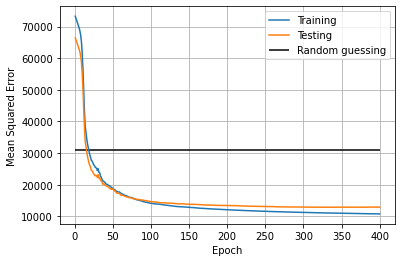

In [24]:
# das sind noch iterations und nicht epochs
nn_plot_epoch_mse(train_mse_dict["model_1"],
                 test_mse_dict["model_1"],
                 mse_mean = mean_squared_error(y_test, np.ones(shape = (len(y_test),))*np.mean(y_test)))